In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from copy import deepcopy

import random
import gc

import random

In [2]:
import _pickle as pickle

def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

In [3]:
sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
submission = pd.read_csv('sample_submission.csv')

prices['id'] = prices['item_id'] + '_' + prices['store_id'] +'_'+ 'validation'

## Building a dico to export ids into state, dept, store, ...

In [ ]:
dico_id = {}

sales.index = sales['id']

for elt in tqdm(sales['id'].unique()):
    a = sales.loc[elt]
    
    item_id = a['item_id']
    dept_id = a['dept_id']
    store_id = a['store_id']
    cat_id = a['cat_id']
    state_id = a['state_id']
    
#     dico_id[elt] = (item_id, dept_id, store_id, cat_id, state_id)
    dico_id[elt] = (cat_id, dept_id, item_id, state_id, store_id)

In [ ]:
save(dico_id, 'dico_id', 'data')

## Building data2 Calendar

In [ ]:
calendar.index = calendar['d']

In [ ]:
data2 = deepcopy(calendar)

In [ ]:
data2

In [ ]:
data2 = data2[['wm_yr_wk', 'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']]

In [ ]:
data2 = data2.fillna(-1)

In [ ]:
data2.columns

In [ ]:
def categorise(df, col):
    unique = df[col].unique()
    
    dico = {}
    for i, elt in enumerate(unique):
        dico[elt] = i
    
    df = df.replace({col: dico})
    return df, dico

In [ ]:
data2, dico_wday = categorise(data2, 'wday')
data2, dico_month = categorise(data2, 'month')
data2, dico_year = categorise(data2, 'year')
data2, dico_event_name_1 = categorise(data2, 'event_name_1')
data2, dico_event_type_1 = categorise(data2, 'event_type_1')
data2, dico_event_name_2 = categorise(data2, 'event_name_2')
data2, dico_event_type_2 = categorise(data2, 'event_type_2')

dicos = {'dico_wday':dico_wday, 'dico_month':dico_month, 'dico_year':dico_year,
         'dico_event_name_1':dico_event_name_1, 'dico_event_type_1':dico_event_type_1, 
         'dico_event_name_2':dico_event_name_2, 'dico_event_type_2':dico_event_type_2 }

save(dicos, 'dico_events', 'data')

save(data2, 'data2', 'data')

In [ ]:
data2

## Building data3 Prices

adding day information

In [ ]:
date_ref = load('data2', 'data')
date_ref.index = date_ref['wm_yr_wk']
date_ref = date_ref[['d']]
prices.index = prices['wm_yr_wk']

In [ ]:
prices = prices.join(date_ref, how = 'left')

In [ ]:
data3 = sales[['id', 'store_id', 'state_id', 'item_id']]
data3.index = data3['id'] 

# data3['ISs'] = data3['item_id'] + '_' + data3['store_id']
data3['IS'] = data3['item_id'] + '_' + data3['state_id']
data3['I'] = data3['item_id']

In [ ]:
data3.head()

In [ ]:
for elt in tqdm(prices['d'].unique()):
    temp = prices[prices['d'] == elt]
    temp.index = temp['id']
    temp = temp[['sell_price']]
    temp.columns = [elt]
    data3 = data3.join(temp, how = 'left')

In [ ]:
data3

In [ ]:
state_price = data3.groupby('IS').mean()
state_price = state_price.reset_index()
state_price['IS'] = state_price['IS'].apply(lambda x : x+'_validation')
state_price.columns = ['id'] + [elt for elt in state_price.columns[1:]]

ex state id : 'FOODS_1_001_CA_validation'

In [ ]:
global_price = data3.groupby('I').mean()
global_price = global_price.reset_index()
global_price['I'] = global_price['I'].apply(lambda x : x+'_validation')
global_price.columns = ['id'] + [elt for elt in global_price.columns[1:]]

ex global id : 'FOODS_1_005_validation'

In [ ]:
data3.columns

In [ ]:
data3 = data3.drop(columns = ['store_id', 'state_id', 'item_id', 'IS', 'I'])
data3 = pd.concat([data3, state_price, global_price])
data3.index = data3['id']

In [ ]:
data3

In [ ]:
save(data3, 'data3', 'data')

In [ ]:
data3 = load('data3', 'data')

## Building data5 quantity

In [ ]:
data5 = deepcopy(sales)
data5['IS'] = data5['item_id'] + '_' + data5['state_id']
data5['I'] = data5['item_id']

In [ ]:
state_q = data5.groupby('IS').sum()
state_q = state_q.reset_index()
state_q['IS'] = state_q['IS'].apply(lambda x : x+'_validation')
state_q.columns = ['id'] + [elt for elt in state_q.columns[1:]]

ex state q : 'FOODS_1_001_CA_validation'

In [ ]:
global_q = data5.groupby('I').sum()
global_q = global_q.reset_index()
global_q['I'] = global_q['I'].apply(lambda x : x+'_validation')
global_q.columns = ['id'] + [elt for elt in global_q.columns[1:]]

ex global q : 'FOODS_1_003_validation'

In [ ]:
data5 = data5.drop(columns = ['item_id','dept_id', 'cat_id', 'store_id', 'state_id', 'IS', 'I'])
data5 = pd.concat([data5, state_q, global_q])
data5.index = data5['id']
save(data5, 'data5', 'data')

## Building data1 sales

In [ ]:
data3 = load('data3', 'data')
data5 = load('data5', 'data')
dico_id = load('dico_id', 'data')

In [ ]:
data3 = data3.loc[list(dico_id.keys())]
data5 = data5.loc[list(dico_id.keys())]

In [ ]:
data3 = data3.fillna(-1)
data1 = deepcopy(data5)
cols = data5.columns[1:]

d3 = data3[cols].values
d1 = data1[cols].values

d1 = (d1*d3)

for i, elt in tqdm(enumerate(cols), total = len(cols)):
    data1[elt] = d1[:,i]
    
save(data1, 'data1', 'data')

## Building data 4 granular sales

In [ ]:
data1 = load('data1', 'data')
dico_id = load('dico_id', 'data')

In [ ]:
data1['cat_id'] = data1['id'].apply(lambda x : dico_id[x][0])
data1['dept_id'] = data1['id'].apply(lambda x : dico_id[x][1])
data1['item_id'] = data1['id'].apply(lambda x : dico_id[x][2])
data1['state_id'] = data1['id'].apply(lambda x : dico_id[x][3])
data1['store_id'] = data1['id'].apply(lambda x : dico_id[x][4])

data1['IS'] = data1['item_id'] + '_' + data1['state_id']
data1['I'] = data1['item_id']

data1['DSs'] = data1['dept_id'] + '_' + data1['store_id']
data1['DS'] = data1['dept_id'] + '_' + data1['state_id']
data1['D'] = data1['dept_id']

data1['CSs'] = data1['cat_id'] + '_' + data1['store_id']
data1['CS'] = data1['cat_id'] + '_' + data1['state_id']
data1['C'] = data1['cat_id']

data1['S'] = data1['state_id']
data1['s'] = data1['store_id']
data1['Global'] = 'Global'

In [ ]:
def build(col):
    c = data1.groupby(col).sum()
    c = c.reset_index()
    c[col] = c[col].apply(lambda x : x+'_validation')
    c.columns = ['id'] + [elt for elt in c.columns[1:]]
    return c

In [ ]:
c = build('CS')

In [ ]:
df = []
list1 = ['IS', 'I', 'DSs', 'DS', 'D', 'CSs', 'CS', 'C', 'S', 's', 'Global']

for elt in list1 : 
    df.append(build(elt))
    
data4 = pd.concat(df)

In [ ]:
save(data4, 'data4', 'data')

## Building a train and test set

In [4]:
data1 = load('data1', 'data') # Sales
data2 = load('data2', 'data') # Event
data3 = load('data3', 'data') # Price
data4 = load('data4', 'data') # Sales granular
data5 = load('data5', 'data') # Quantity

data6 = pd.concat([data1, data4])
data6.index = data6['id']
data3 = data3.fillna(-1)
dico_id = load('dico_id', 'data')

In [5]:
feature_list = [
#     'cat',
#     'dep',
#     'item',
#     'state',
#     'store',
    
    'wday',
    'month',
    'year',
    
    
    'name1',
    'type1',
    'name2',
    'type2',
    'snap_ca',
    'snap_tx',
    'snap_wi',
    
    'PISs',
    'PIS',
    'PI',
    
    'ISs',
    'IS',
    'I',
    'DSs',
    'DS',
    'D',
    'CSs',
    'CS',
    'C',
    's',
    'S',
    'Global',
    
    'QISs',
    'QIS',
    'QI'
]


In [6]:
len(feature_list)

28

In [7]:
def build_one_example(item_full_id, end_of_past, past_len = 150, pred_len = 28, train = True, end_of_time = 1914):
    
    vect = np.zeros((past_len + pred_len - 1 , 28))
    
    c_past = ['d_'+str(end_of_past-elt) for elt in range(past_len)]
    c_past.reverse()
    c_pred = ['d_'+str(end_of_past + elt) for elt in range(1,pred_len) if end_of_past + elt < end_of_time]
    c_target = ['d_'+str(end_of_past + elt) for elt in range(1,pred_len+1)]
    
    
    ## Event Data
    a = data2.loc[c_past + c_pred][data2.columns[2:]].values
    vect[:a.shape[0], :10] = a
    
    ## Tags
    cat_id, dept_id, item_id, state_id, store_id = dico_id[item_full_id]

    ISs = item_id + '_' + store_id + '_validation'
    IS = item_id + '_' + state_id + '_validation'
    I = item_id + '_validation'

    DSs = dept_id + '_' + store_id + '_validation'
    DS = dept_id + '_' + state_id + '_validation'
    D = dept_id + '_validation'

    CSs = cat_id + '_' + store_id + '_validation'
    CS = cat_id + '_' + state_id + '_validation'
    C = cat_id + '_validation'

    s = store_id + '_validation'
    S = state_id + '_validation'
    gl = 'Global_validation'

    price_tag = [ISs, IS, I]
    sales_tag = [ISs, IS, I, DSs, DS, D, CSs, CS, C, s, S, gl]
    quantity_tag = [ISs, IS, I]
    
    ## Price Data
    a = data3.loc[price_tag][c_past + c_pred].values.T
    vect[:a.shape[0], 10:13] = a
    
    ## Sales
    a = data6.loc[sales_tag][c_past + c_pred].values.T
    vect[:a.shape[0] , 13:25] = a
    
    ## Quantity input
    a = data5.loc[quantity_tag][c_past + c_pred].values.T
    vect[:a.shape[0] , 25:] = a
    
    ## Target
    if train == True : 
        target = data5.loc[[ISs]][c_target].values[0]
    else:
        target = None
    
    return vect, target

In [23]:
def create_batch(n = 10000, start_eop = 150, end_eop = 1200, past_len = 100, pred_len = 28, end_of_time = 1914):
    X = list(np.zeros(n))
    y = list(np.zeros(n))
    
    pool = data1['id'].unique()
    
    t = list(range(start_eop, end_eop))
    
    for elt in tqdm(range(n)):
        
        item_full_id = random.choice(pool)
        end_of_past = random.choice(t)
        
        vect, target = build_one_example(item_full_id, end_of_past, past_len = past_len, pred_len = 28, train = True, end_of_time=end_of_time)
        
        X[elt] = vect
        y[elt] = target
        
    X = np.array(X)
    y = np.array(y)
    return X, y
    

In [24]:
X, y = create_batch(n = 100, start_eop = 1200, end_eop = 1914, past_len = 100, pred_len = 28, end_of_time = 1914)

###### Test Set

In [27]:
X, y = create_batch(n = 10000, start_eop = 1200, end_eop = 1850, past_len = 100, pred_len = 28, end_of_time = 1914)
save((X,y), 'test_set', 'batch')

###### Train set

In [29]:
for elt in tqdm(range(20)):
    X, y = create_batch(n = 10000, start_eop = 150, end_eop = 1200, past_len = 100, pred_len = 28, end_of_time = 1914)
    save((X,y), 'train_set_'+str(elt), 'batch')

## Building architecture

In [56]:
from tf_transformers2 import *
from tensorflow.keras.layers import Dense, TimeDistributed, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model
import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD

In [254]:
### Parameters
cat_dim = [7,12,6,31,5,5,3]
cat_out_dim = [7,12,6,31,5,5,3]
bidirectional_decoder = False
maximum_position_encoding = 127
d_model = 64
num_heads = 8
dff = 1024
rate = 0.1
num_layers = 1

### Declaration of some layers
pos_encoding = positional_encoding(maximum_position_encoding, d_model)

dec_layers = [GPTDecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

### Model architecture
inputs = Input(shape = (127, 28))

cat_inputs = tf.cast(inputs[:,:,:7], dtype = 'int32')
num_inputs = inputs[:,:,7:]

cats = list(np.zeros(7))
for elt in range(len(cat_dim)):
    cats[elt] = Embedding(cat_dim[elt], cat_out_dim[elt])(cat_inputs[:,:,elt])
    
categorical_embedding = Concatenate(axis = -1)(cats)

num_embedding = TimeDistributed(Dense(28, activation = 'relu'))(num_inputs)

time_series =  Concatenate(axis = -1)([categorical_embedding, num_embedding])

time_series = TimeDistributed(Dense(64, activation = 'relu'))(time_series)

seq_len = tf.shape(time_series)[1]
attention_weights = {}
        
if bidirectional_decoder == False:
    look_ahead_mask = create_look_ahead_mask(seq_len)
#     dec_target_padding_mask = create_padding_mask(x)
#     mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
else:
#     mask = create_padding_mask(x)
    mask = None

# mask = None
time_series *= tf.math.sqrt(tf.cast(d_model, tf.float32))
time_series += pos_encoding[:, :seq_len, :]

time_series = Dropout(rate)(time_series)

x = time_series
for i in range(num_layers):
    x, block1 = dec_layers[i](x, training = True, look_ahead_mask = mask)

    attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
    
prediction = TimeDistributed(Dense(1, activation = 'linear'))(x)

output = prediction[:,-28:,:]

model = Model(inputs, output)

In [255]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 127, 28)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_292 ( [(None, 127, 7)]     0           input_29[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Cast_26 (TensorFlow [(None, 127, 7)]     0           tf_op_layer_strided_slice_292[0][
__________________________________________________________________________________________________
tf_op_layer_strided_slice_294 ( [(None, 127)]        0           tf_op_layer_Cast_26[0][0]        
___________________________________________________________________________________________

In [256]:
X_train, y_train = load('train_set_0', 'batch')
X_test, y_test = load('test_set', 'batch')

In [257]:
from tensorflow.keras.optimizers import Adam, SGD

def rmse(label, prediction):
    RMSE = tf.sqrt(tf.losses.mean_squared_error(label, prediction))
    return RMSE

loss_classif     =  rmse#'mse'# find the right loss for multi-class classification
optimizer        =  Adam(3e-5, 1e-8) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer)#,
#               metrics=metrics_classif)

In [258]:
bs = 8
n_epochs = 5

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test,  y_test))

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.5449 - val_loss: 1.6903
Epoch 2/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.4992 - val_loss: 1.6957
Epoch 3/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.4944 - val_loss: 1.7134
Epoch 4/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.4924 - val_loss: 1.6934
Epoch 5/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.4907 - val_loss: 1.7097


In [165]:
EPOCH = 2

bs = 128
n_epochs = 1

for e in range(EPOCH):
    print('************************         EPOCH  '+str(e)+'    ***************************************')
    
    for b in range(20):
        print('**********************Batch  '+str(b))
        
        X_train, y_train = load('train_set_'+str(b), 'batch')
        
        history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test,  y_test))

************************         EPOCH  0    ***************************************
**********************Batch  0
Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 22s 2ms/sample - loss: 14.7318 - val_loss: 16.1880
**********************Batch  1
Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 17s 2ms/sample - loss: 20.6611 - val_loss: 16.1880
**********************Batch  2
Train on 10000 samples, validate on 10000 samples
10000/10000 [==============================] - 17s 2ms/sample - loss: 16.3937 - val_loss: 16.1880
**********************Batch  3
Train on 10000 samples, validate on 10000 samples
 2560/10000 [======>.......................] - ETA: 8s - loss: 19.4734

KeyboardInterrupt: 

In [259]:
ind = 1106
a = model.predict(X_train[ind:ind+1])
a = a.reshape(a.shape[1])
b = y_train[ind]

In [260]:
a

array([0.09718734, 0.08795158, 0.0790975 , 0.06608121, 0.05314694,
       0.03076402, 0.07591003, 0.12050926, 0.05555088, 0.10176709,
       0.04196538, 0.02705426, 0.07230114, 0.07384706, 0.07674184,
       0.06930135, 0.09066   , 0.03451683, 0.10416551, 0.0569393 ,
       0.04092109, 0.05007923, 0.11880596, 0.05527979, 0.07599157,
       0.0599381 , 0.09939766, 0.01635136], dtype=float32)

In [261]:
b

array([0, 3, 2, 3, 1, 1, 1, 0, 1, 8, 1, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0,
       0, 5, 2, 1, 1, 1], dtype=int64)

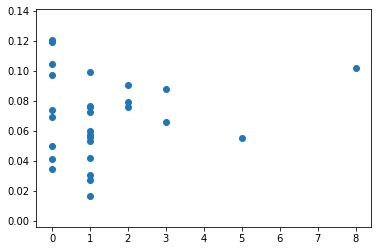

In [262]:
plt.scatter(b, a)